In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render li, div.text_cell_render p, code{font-size:22pt; line-height:40px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

# 1. 날씨 민감도 TOP 5 업종만 확대 시각화

         TYPE  DAYS  TEMP_CORR  RAIN_CORR  TEMP_ABS  RAIN_ABS  WEATHER_SCORE
0       커피/음료  1035  -0.237065  -0.013950  0.237065  0.013950      17.013071
1          한식  1035  -0.190211   0.021376  0.190211  0.021376      13.956029
2          분식  1035   0.110368   0.038073  0.110368  0.038073       8.867958
3  제과/제빵/떡/케익  1035  -0.092257  -0.044305  0.092257  0.044305       7.787112
4      일식/수산물  1035  -0.090776  -0.045133  0.090776  0.045133       7.708323


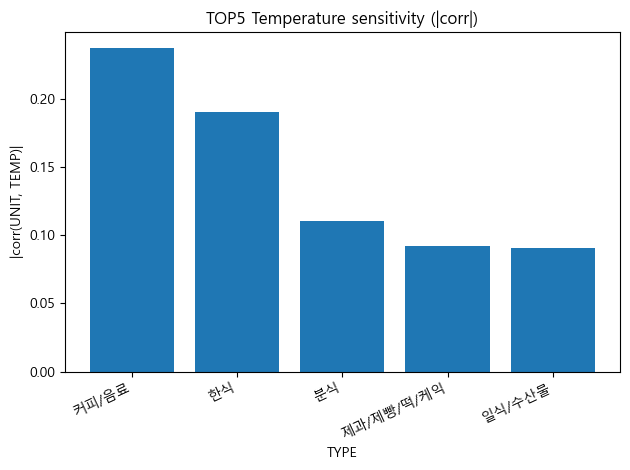

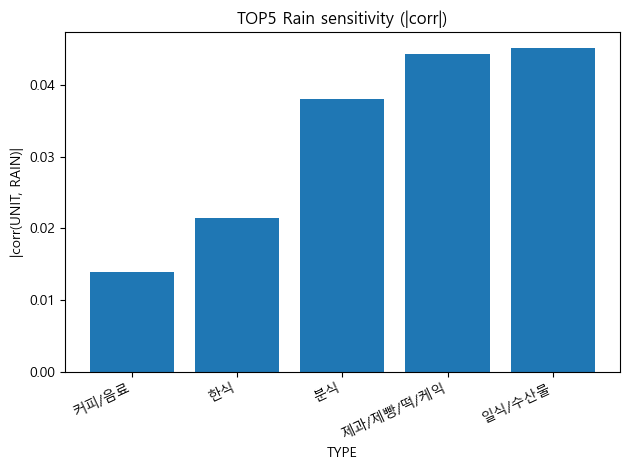

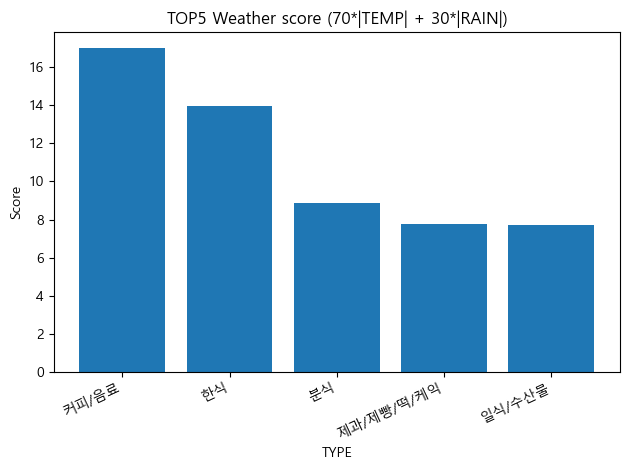

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def set_korean_font():
    import platform
    sys = platform.system()
    if sys == "Windows":
        plt.rcParams["font.family"] = "Malgun Gothic"
    elif sys == "Darwin":
        plt.rcParams["font.family"] = "AppleGothic"
    else:
        plt.rcParams["font.family"] = ["NanumGothic", "Noto Sans CJK KR", "DejaVu Sans"]
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# ====== 데이터 로드 ======
DATA_CSV = r"//192.168.0.230/data/SUWON_FOOD_DATA_TABLE.csv"
df = pd.read_csv(DATA_CSV)

# 일자(TA_YMD) x 업종(TYPE) 단위로 집계 (UNIT=일 매출/판매량 합)
daily = (
    df.groupby(["TA_YMD", "TYPE"], as_index=False)
      .agg(
          UNIT=("UNIT", "sum"),
          TEMP=("TEMP", "mean"),
          RAIN=("RAIN", "mean"),
          DAY=("DAY", "first"),
          N=("UNIT", "size"),
      )
)

# ====== 업종별 상관계수/민감도 계산 ======
rows = []
for t, g in daily.groupby("TYPE"):
    if len(g) < 30:
        continue
    temp_corr = g["UNIT"].corr(g["TEMP"])
    rain_corr = g["UNIT"].corr(g["RAIN"])

    temp_abs = abs(temp_corr) if pd.notna(temp_corr) else 0.0
    rain_abs = abs(rain_corr) if pd.notna(rain_corr) else 0.0

    # 기존 점수 규칙과 동일: 70*|TEMP| + 30*|RAIN|
    score = 70 * temp_abs + 30 * rain_abs

    rows.append({
        "TYPE": t,
        "DAYS": len(g),
        "TEMP_CORR": temp_corr,
        "RAIN_CORR": rain_corr,
        "TEMP_ABS": temp_abs,
        "RAIN_ABS": rain_abs,
        "WEATHER_SCORE": score
    })

sens = pd.DataFrame(rows).sort_values("WEATHER_SCORE", ascending=False).reset_index(drop=True)
top5 = sens.head(5).copy()
print(top5)

# ====== TOP5 그래프 ======
plt.figure()
plt.bar(top5["TYPE"].astype(str), top5["TEMP_ABS"])
plt.xticks(rotation=25, ha="right")
plt.title("TOP5 Temperature sensitivity (|corr|)")
plt.xlabel("TYPE")
plt.ylabel("|corr(UNIT, TEMP)|")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(top5["TYPE"].astype(str), top5["RAIN_ABS"])
plt.xticks(rotation=25, ha="right")
plt.title("TOP5 Rain sensitivity (|corr|)")
plt.xlabel("TYPE")
plt.ylabel("|corr(UNIT, RAIN)|")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(top5["TYPE"].astype(str), top5["WEATHER_SCORE"])
plt.xticks(rotation=25, ha="right")
plt.title("TOP5 Weather score (70*|TEMP| + 30*|RAIN|)")
plt.xlabel("TYPE")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


# 2. 날씨별

더운 날 기준 (상위 10%): TEMP >= 26.25
추운 날 기준 (하위 10%): TEMP <= -2.10


<Figure size 1200x600 with 0 Axes>

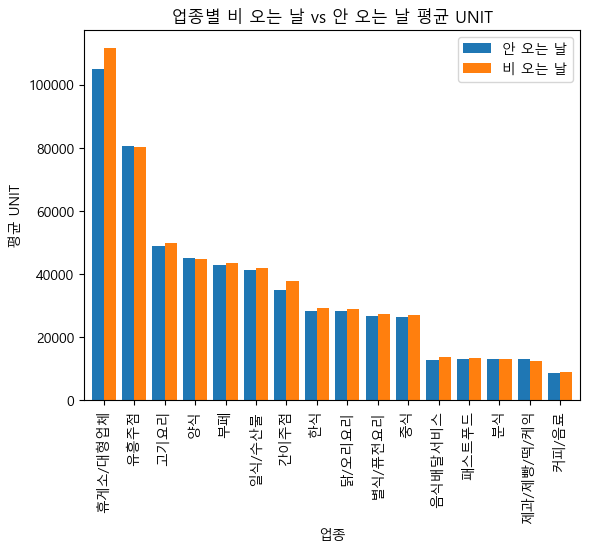

저장: C:\ai\source\10_1stProject\viz_output\20_type_rain_vs_norain_avg_unit.png


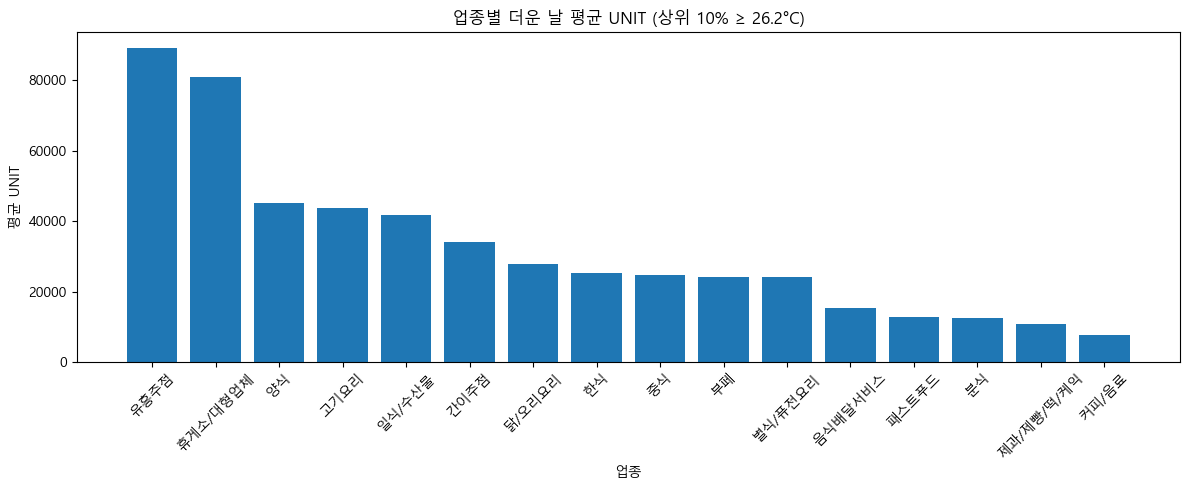

저장: C:\ai\source\10_1stProject\viz_output\21_type_hotday_avg_unit.png


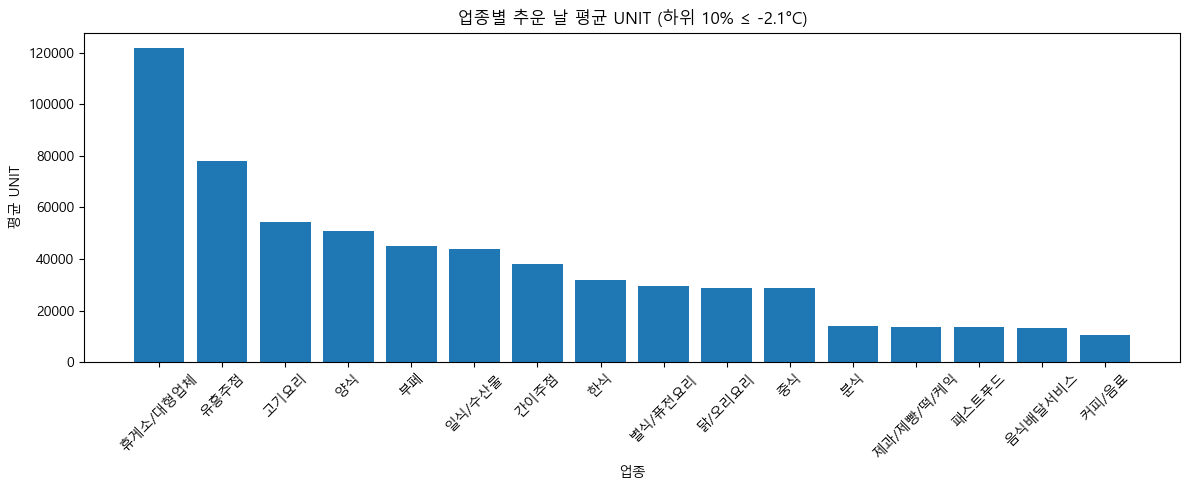

저장: C:\ai\source\10_1stProject\viz_output\22_type_coldday_avg_unit.png


In [3]:
"""
업종별 날씨 조건 비교 시각화
1) 비 오는 날 vs 안 오는 날 평균 UNIT 비교
2) 더운날 / 추운날 기준을 분위수(상·하위 10%)로 자동 설정
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) 설정
# =========================
DATA_PATH = r"//192.168.0.230/data/SUWON_FOOD_DATA_TABLE.csv"
OUT_DIR = "./viz_output"
os.makedirs(OUT_DIR, exist_ok=True)

def save_show(fig, filename):
    path = os.path.join(OUT_DIR, filename)
    fig.tight_layout()
    fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()
    print("저장:", os.path.abspath(path))

def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# =========================
# 2) 데이터 로드 & 컬럼 탐색
# =========================
df = pd.read_csv(DATA_PATH)

# 날짜
if "TA_YMD" in df.columns:
    df["DATE"] = pd.to_datetime(df["TA_YMD"].astype(str), format="%Y%m%d", errors="coerce")

COL_UNIT = pick_first_existing(df, ["UNIT", "AMT", "amt", "매출"])
COL_TEMP = pick_first_existing(df, ["TEMP", "temp", "기온"])
COL_RAIN = pick_first_existing(df, ["RAIN", "rain", "강수", "강수량"])
COL_TYPE = pick_first_existing(df, ["TYPE", "type", "업종"])

col_map = {"UNIT": COL_UNIT, "TEMP": COL_TEMP, "RAIN": COL_RAIN, "TYPE": COL_TYPE}
missing = [k for k, v in col_map.items() if v is None]
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}\n현재 컬럼: {df.columns.tolist()}")

# 숫자 변환
for c in [COL_UNIT, COL_TEMP, COL_RAIN]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[COL_UNIT, COL_TEMP, COL_RAIN, COL_TYPE]).copy()

# =========================
# 3) 분위수 기반 더운날 / 추운날 자동 기준
# =========================
hot_threshold = df[COL_TEMP].quantile(0.9)
cold_threshold = df[COL_TEMP].quantile(0.1)

print(f"더운 날 기준 (상위 10%): TEMP >= {hot_threshold:.2f}")
print(f"추운 날 기준 (하위 10%): TEMP <= {cold_threshold:.2f}")

df["IS_RAIN"] = df[COL_RAIN] > 0
df["IS_HOT"] = df[COL_TEMP] >= hot_threshold
df["IS_COLD"] = df[COL_TEMP] <= cold_threshold

# =========================
# 4) 업종별 비 오는 날 vs 안 오는 날 평균 UNIT
# =========================
rain_compare = (
    df.groupby([COL_TYPE, "IS_RAIN"], as_index=False)[COL_UNIT]
      .mean()
)

pivot_rain = rain_compare.pivot(
    index=COL_TYPE,
    columns="IS_RAIN",
    values=COL_UNIT
).fillna(0)

pivot_rain.columns = ["안 오는 날", "비 오는 날"]

pivot_rain = pivot_rain.sort_values("비 오는 날", ascending=False)

fig = plt.figure(figsize=(12, 6))
pivot_rain.plot(kind="bar", width=0.8)
plt.title("업종별 비 오는 날 vs 안 오는 날 평균 UNIT")
plt.xlabel("업종")
plt.ylabel("평균 UNIT")
plt.legend()
save_show(fig, "20_type_rain_vs_norain_avg_unit.png")

# =========================
# 5) 업종별 더운날 / 추운날 평균 UNIT 비교
# =========================
def plot_hot_cold(data, flag_col, title, filename):
    tmp = (
        data[data[flag_col]]
        .groupby(COL_TYPE, as_index=False)[COL_UNIT]
        .mean()
        .sort_values(COL_UNIT, ascending=False)
    )

    fig = plt.figure(figsize=(12, 5))
    plt.bar(tmp[COL_TYPE].astype(str), tmp[COL_UNIT])
    plt.title(title)
    plt.xlabel("업종")
    plt.ylabel("평균 UNIT")
    plt.xticks(rotation=45)
    save_show(fig, filename)

plot_hot_cold(
    df,
    "IS_HOT",
    f"업종별 더운 날 평균 UNIT (상위 10% ≥ {hot_threshold:.1f}°C)",
    "21_type_hotday_avg_unit.png"
)

plot_hot_cold(
    df,
    "IS_COLD",
    f"업종별 추운 날 평균 UNIT (하위 10% ≤ {cold_threshold:.1f}°C)",
    "22_type_coldday_avg_unit.png"
)


# 3. 요일별

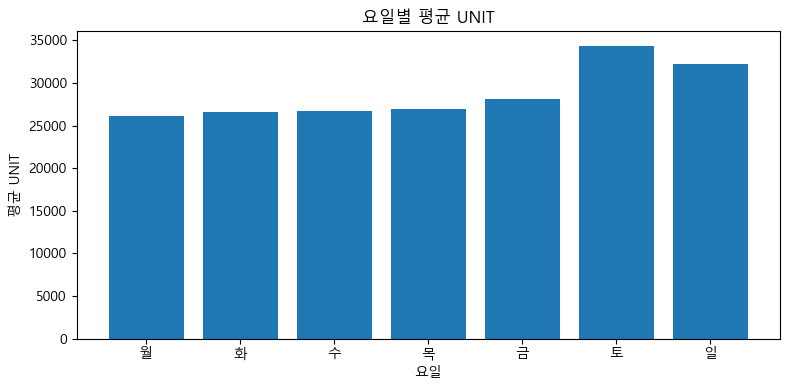

저장: C:\ai\source\10_1stProject\viz_output\30_dayofweek_avg_unit_bar.png


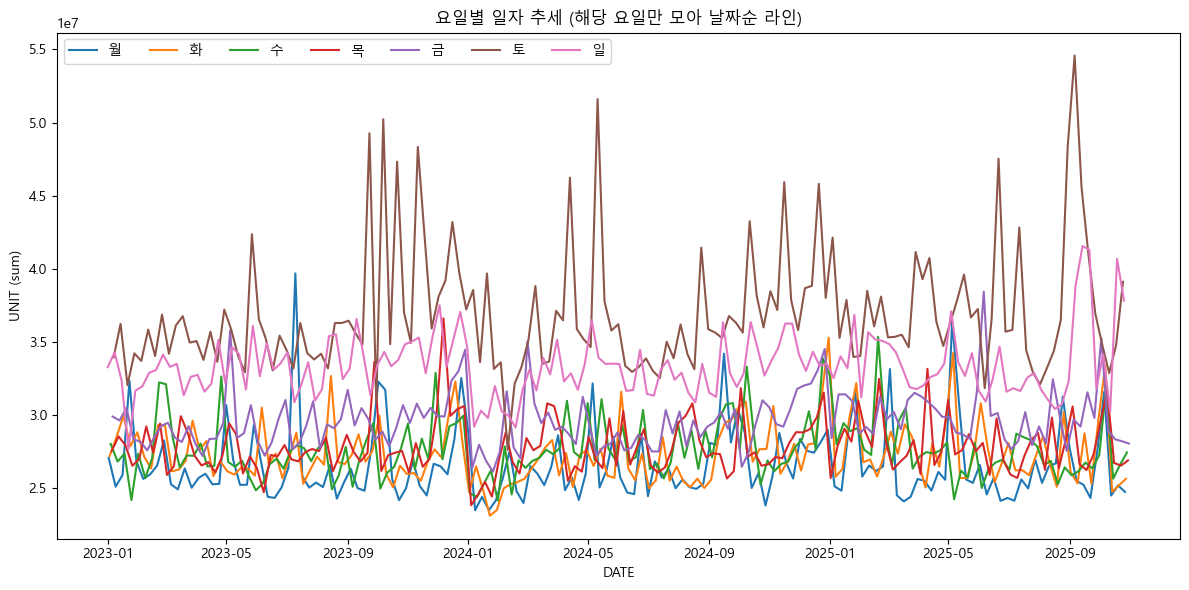

저장: C:\ai\source\10_1stProject\viz_output\31_dayofweek_trend_lines.png


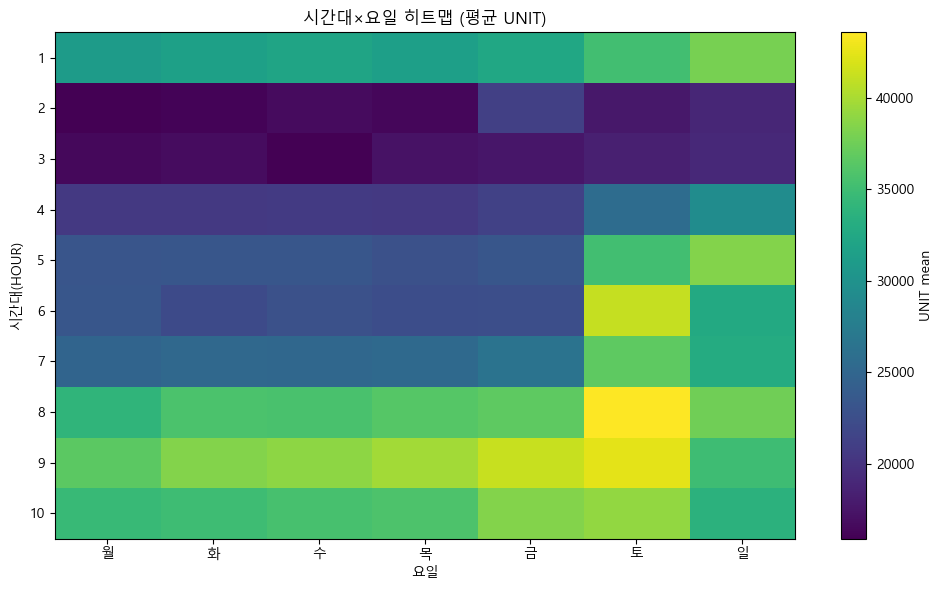

저장: C:\ai\source\10_1stProject\viz_output\32_hour_x_day_heatmap_mean_unit.png


In [4]:


# =========================
# 1) Load
# =========================
df = pd.read_csv(DATA_PATH)

# DATE 만들기
if "TA_YMD" in df.columns:
    df["DATE"] = pd.to_datetime(df["TA_YMD"].astype(str), format="%Y%m%d", errors="coerce")
elif "DATE" in df.columns:
    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
else:
    raise ValueError("TA_YMD 또는 DATE 컬럼이 필요합니다.")

COL_UNIT = pick_first_existing(df, ["UNIT", "AMT", "amt", "매출"])
COL_DAY  = pick_first_existing(df, ["DAY", "day", "요일"])
COL_HOUR = pick_first_existing(df, ["HOUR", "hour", "시간대"])  # 있으면 히트맵 추가

if COL_UNIT is None or COL_DAY is None:
    raise ValueError(f"필수 컬럼 누락: UNIT({COL_UNIT}), DAY({COL_DAY})\n현재 컬럼:{df.columns.tolist()}")

df[COL_UNIT] = pd.to_numeric(df[COL_UNIT], errors="coerce")
df = df.dropna(subset=["DATE", COL_UNIT, COL_DAY]).copy()

# =========================
# 2) 요일 값 정리(숫자/문자 대응)
# =========================
# DAY가 0~6/1~7 같은 숫자면 한글 요일로 매핑
day_map_0to6 = {0:"월",1:"화",2:"수",3:"목",4:"금",5:"토",6:"일"}
day_map_1to7 = {1:"월",2:"화",3:"수",4:"목",5:"금",6:"토",7:"일"}

# 문자열이면 그대로 쓰되 공백 제거
if np.issubdtype(df[COL_DAY].dtype, np.number):
    vals = df[COL_DAY].astype(int)
    if set(vals.unique()).issubset(set(day_map_0to6.keys())):
        df["DAY_KR"] = vals.map(day_map_0to6)
    elif set(vals.unique()).issubset(set(day_map_1to7.keys())):
        df["DAY_KR"] = vals.map(day_map_1to7)
    else:
        df["DAY_KR"] = vals.astype(str)
else:
    df["DAY_KR"] = df[COL_DAY].astype(str).str.strip()

# 보기 좋은 순서(월~일)
order = ["월","화","수","목","금","토","일"]
# 데이터에 그 외 값이 있으면 뒤에 붙임
extra = [x for x in df["DAY_KR"].unique().tolist() if x not in order]
day_order = order + sorted(extra)

# =========================
# 3) (1) 요일별 평균 UNIT (Bar)
# =========================
g_mean = (df.groupby("DAY_KR", as_index=False)[COL_UNIT].mean())
g_mean["DAY_KR"] = pd.Categorical(g_mean["DAY_KR"], categories=day_order, ordered=True)
g_mean = g_mean.sort_values("DAY_KR")

fig = plt.figure(figsize=(8, 4))
plt.bar(g_mean["DAY_KR"].astype(str), g_mean[COL_UNIT])
plt.title("요일별 평균 UNIT")
plt.xlabel("요일")
plt.ylabel("평균 UNIT")
save_show(fig, "30_dayofweek_avg_unit_bar.png")

# =========================
# 4) (2) 요일별 '추세' 라인 (각 요일만 골라 날짜순)
#     - 요일별로 날짜별 합계/평균을 만든 후 라인으로 비교
# =========================
daily_by_day = (df.groupby(["DATE", "DAY_KR"], as_index=False)[COL_UNIT].sum()
                .sort_values("DATE"))

fig = plt.figure(figsize=(12, 6))
for d in [x for x in day_order if x in daily_by_day["DAY_KR"].unique()]:
    sub = daily_by_day[daily_by_day["DAY_KR"] == d]
    plt.plot(sub["DATE"], sub[COL_UNIT], label=str(d))
plt.title("요일별 일자 추세 (해당 요일만 모아 날짜순 라인)")
plt.xlabel("DATE")
plt.ylabel("UNIT (sum)")
plt.legend(ncol=7, fontsize=10)
save_show(fig, "31_dayofweek_trend_lines.png")

# =========================
# 5) (3) 요일×시간대 히트맵(평균 UNIT) - HOUR 컬럼 있을 때만
# =========================
if COL_HOUR is not None and COL_HOUR in df.columns:
    tmp = df.dropna(subset=[COL_HOUR]).copy()
    tmp[COL_HOUR] = pd.to_numeric(tmp[COL_HOUR], errors="coerce")
    tmp = tmp.dropna(subset=[COL_HOUR]).copy()
    tmp[COL_HOUR] = tmp[COL_HOUR].astype(int)

    pivot = tmp.pivot_table(index=COL_HOUR, columns="DAY_KR", values=COL_UNIT, aggfunc="mean")
    # 요일 순서 정렬
    pivot = pivot.reindex(columns=[c for c in day_order if c in pivot.columns])
    pivot = pivot.sort_index()

    fig = plt.figure(figsize=(10, 6))
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label="UNIT mean")
    plt.title("시간대×요일 히트맵 (평균 UNIT)")
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=0)
    plt.xlabel("요일")
    plt.ylabel("시간대(HOUR)")
    save_show(fig, "32_hour_x_day_heatmap_mean_unit.png")
else:
    print("[INFO] HOUR 컬럼이 없어 '시간대×요일 히트맵'은 생략했습니다.")


# 4. 업종별 모든 조건

<Figure size 1400x600 with 0 Axes>

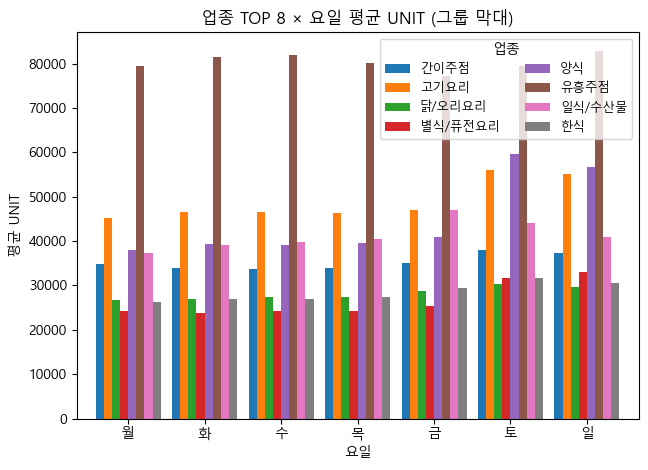

저장: C:\ai\source\10_1stProject\viz_output\40_top_types_x_day_avg_unit_groupbar.png
[INFO] 더운날(상위10%) TEMP >= 26.25
[INFO] 추운날(하위10%) TEMP <= -2.10


<Figure size 1400x600 with 0 Axes>

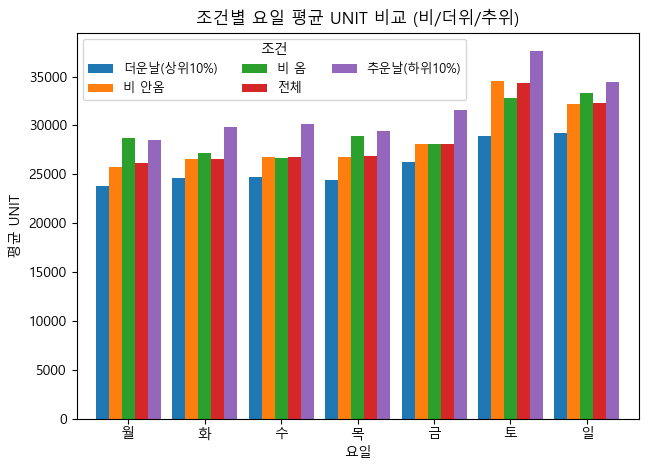

저장: C:\ai\source\10_1stProject\viz_output\41_conditions_x_day_avg_unit_groupbar.png


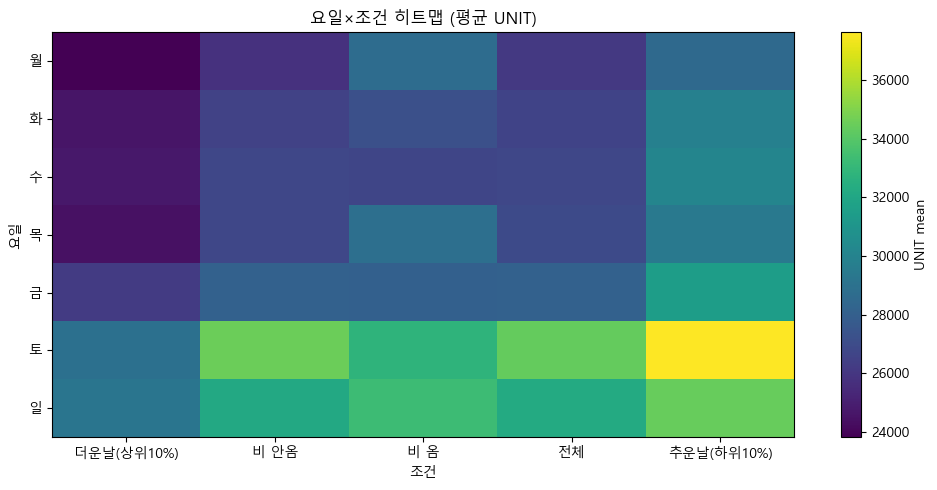

저장: C:\ai\source\10_1stProject\viz_output\42_day_x_conditions_heatmap_mean_unit.png


In [5]:
# =========================
# [추가 1] 업종 TOP N × 요일 평균 UNIT (그룹 막대)
# =========================
COL_TYPE = pick_first_existing(df, ["TYPE", "type", "업종"])
COL_TEMP = pick_first_existing(df, ["TEMP", "temp", "기온"])
COL_RAIN = pick_first_existing(df, ["RAIN", "rain", "강수", "강수량"])

if COL_TYPE is None:
    print("[SKIP] TYPE 컬럼이 없어 '업종×요일' 그래프는 생략합니다.")
else:
    TOP_N_TYPES = 8

    # 업종 TOP N 선정(총 UNIT 기준)
    top_types = (df.groupby(COL_TYPE)[COL_UNIT].sum()
                   .sort_values(ascending=False)
                   .head(TOP_N_TYPES).index.tolist())

    d = df[df[COL_TYPE].isin(top_types)].copy()

    # 업종×요일 평균
    pivot = d.pivot_table(index="DAY_KR", columns=COL_TYPE, values=COL_UNIT, aggfunc="mean").fillna(0)

    # 요일 순서 정렬(앞에서 만든 day_order 사용)
    pivot = pivot.reindex([x for x in day_order if x in pivot.index])

    fig = plt.figure(figsize=(14, 6))
    pivot.plot(kind="bar", width=0.85)
    plt.title(f"업종 TOP {TOP_N_TYPES} × 요일 평균 UNIT (그룹 막대)")
    plt.xticks(rotation=0, ha="center")
    plt.tight_layout()
    plt.xlabel("요일")
    plt.ylabel("평균 UNIT")
    plt.legend(title="업종", ncol=2, fontsize=9)
    save_show(fig, "40_top_types_x_day_avg_unit_groupbar.png")


# =========================
# [추가 2] 비/더위/추위 조건별 요일 패턴 비교
#  - 더위/추위는 분위수 자동 설정(상위 10%, 하위 10%)
# =========================
if (COL_TEMP is None) or (COL_RAIN is None):
    print("[SKIP] TEMP 또는 RAIN 컬럼이 없어 '비/더위/추위 요일 비교'는 생략합니다.")
else:
    # 분위수 기반 임계값
    hot_th = df[COL_TEMP].dropna().quantile(0.90)
    cold_th = df[COL_TEMP].dropna().quantile(0.10)

    print(f"[INFO] 더운날(상위10%) TEMP >= {hot_th:.2f}")
    print(f"[INFO] 추운날(하위10%) TEMP <= {cold_th:.2f}")

    base = df.dropna(subset=[COL_TEMP, COL_RAIN]).copy()

    conds = {
        "전체": base,
        "비 안옴": base[base[COL_RAIN] <= 0],
        "비 옴": base[base[COL_RAIN] > 0],
        "더운날(상위10%)": base[base[COL_TEMP] >= hot_th],
        "추운날(하위10%)": base[base[COL_TEMP] <= cold_th],
    }

    # 조건별 요일 평균 UNIT 테이블 만들기
    table = []
    for name, sub in conds.items():
        if sub.empty:
            continue
        g = sub.groupby("DAY_KR", as_index=False)[COL_UNIT].mean()
        g["COND"] = name
        table.append(g)

    comp = pd.concat(table, ignore_index=True)

    # 피벗: 요일(행) × 조건(열)
    pivot = comp.pivot_table(index="DAY_KR", columns="COND", values=COL_UNIT, aggfunc="mean").fillna(0)
    pivot = pivot.reindex([x for x in day_order if x in pivot.index])

    # (2-1) 그룹 막대: 요일별로 조건 비교
    fig = plt.figure(figsize=(14, 6))
    pivot.plot(kind="bar", width=0.85)
    plt.title("조건별 요일 평균 UNIT 비교 (비/더위/추위)")
    plt.xticks(rotation=0, ha="center")
    plt.tight_layout()
    plt.xlabel("요일")
    plt.ylabel("평균 UNIT")
    plt.legend(title="조건", ncol=3, fontsize=9)
    save_show(fig, "41_conditions_x_day_avg_unit_groupbar.png")

    # (2-2) 히트맵: 요일×조건 (평균 UNIT)
    # 값 크기 패턴을 한눈에 보기 좋음
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label="UNIT mean")
    plt.title("요일×조건 히트맵 (평균 UNIT)")
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=0, ha="center")
    plt.xlabel("조건")
    plt.ylabel("요일")
    save_show(fig, "42_day_x_conditions_heatmap_mean_unit.png")


CSV 저장: C:\ai\source\10_1stProject\viz_output\recommendation\recommendation_table.csv


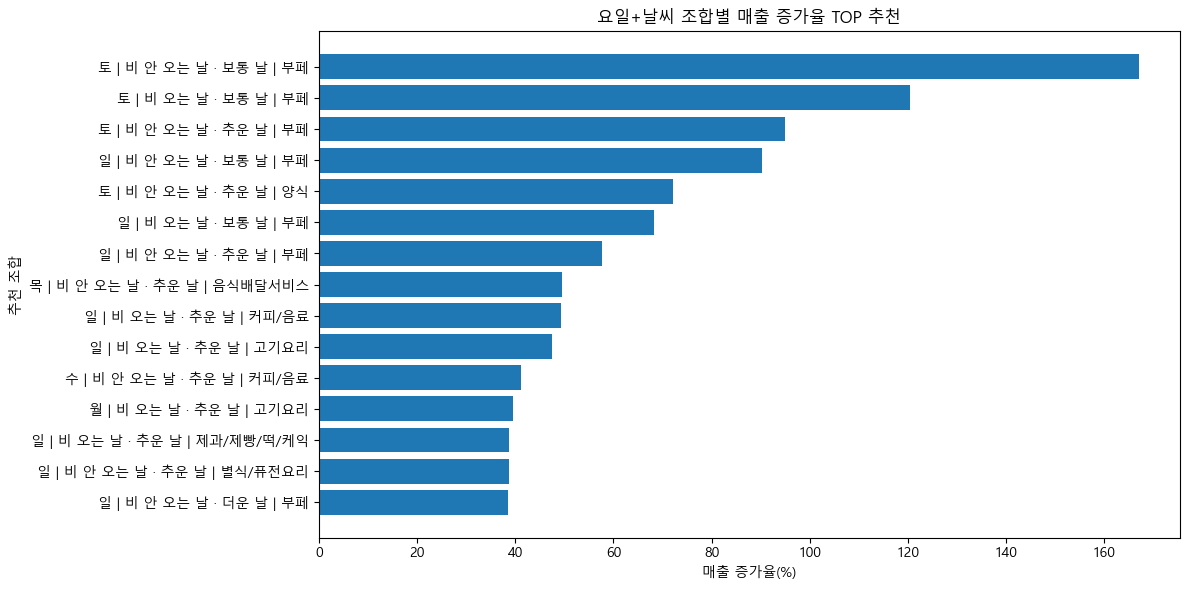

이미지 저장: C:\ai\source\10_1stProject\viz_output\recommendation\top_recommendations_bar.png

 추천 TOP
 - 📈 토 · 비 안 오는 날 · 보통 날에는 '부페' 업종 매출이 평균 대비 167.2% 증가
 - 📈 토 · 비 오는 날 · 보통 날에는 '부페' 업종 매출이 평균 대비 120.5% 증가
 - 📈 토 · 비 안 오는 날 · 추운 날에는 '부페' 업종 매출이 평균 대비 94.9% 증가
 - 📈 일 · 비 안 오는 날 · 보통 날에는 '부페' 업종 매출이 평균 대비 90.2% 증가
 - 📈 토 · 비 안 오는 날 · 추운 날에는 '양식' 업종 매출이 평균 대비 72.2% 증가
 - 📈 일 · 비 오는 날 · 보통 날에는 '부페' 업종 매출이 평균 대비 68.4% 증가
 - 📈 일 · 비 안 오는 날 · 추운 날에는 '부페' 업종 매출이 평균 대비 57.7% 증가
 - 📈 목 · 비 안 오는 날 · 추운 날에는 '음식배달서비스' 업종 매출이 평균 대비 49.5% 증가
 - 📈 일 · 비 오는 날 · 추운 날에는 '커피/음료' 업종 매출이 평균 대비 49.3% 증가
 - 📈 일 · 비 오는 날 · 추운 날에는 '고기요리' 업종 매출이 평균 대비 47.4% 증가
 - 📈 수 · 비 안 오는 날 · 추운 날에는 '커피/음료' 업종 매출이 평균 대비 41.3% 증가
 - 📈 월 · 비 오는 날 · 추운 날에는 '고기요리' 업종 매출이 평균 대비 39.5% 증가
 - 📈 일 · 비 오는 날 · 추운 날에는 '제과/제빵/떡/케익' 업종 매출이 평균 대비 38.8% 증가
 - 📈 일 · 비 안 오는 날 · 추운 날에는 '별식/퓨전요리' 업종 매출이 평균 대비 38.6% 증가
 - 📈 일 · 비 안 오는 날 · 더운 날에는 '부페' 업종 매출이 평균 대비 38.4% 증가


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) 설정
# =========================
OUT_DIR = "./viz_output/recommendation"
os.makedirs(OUT_DIR, exist_ok=True)

Q_RATIO = 0.10     # 더위/추위 분위수 기준
RAIN_TH = 0.0      # 비 기준
TOP_K = 15         # 추천 TOP K 조합

# =========================
# =========================
# 2) 데이터 로드 & 컬럼 탐지
# =========================
df = pd.read_csv(DATA_PATH)

# 날짜
if "TA_YMD" in df.columns:
    df["DATE"] = pd.to_datetime(df["TA_YMD"].astype(str), format="%Y%m%d", errors="coerce")

def pick(df, cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

COL_UNIT = pick(df, ["UNIT", "AMT", "amt", "매출"])
COL_TEMP = pick(df, ["TEMP", "temp", "기온"])
COL_RAIN = pick(df, ["RAIN", "rain", "강수", "강수량"])
COL_TYPE = pick(df, ["TYPE", "type", "업종"])
COL_DAY  = pick(df, ["DAY", "day", "요일"])

for c in [COL_UNIT, COL_TEMP, COL_RAIN]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[COL_UNIT, COL_TEMP, COL_RAIN, COL_TYPE, COL_DAY]).copy()

# =========================
# 3) 요일 정규화
# =========================
day_map = {0:"월",1:"화",2:"수",3:"목",4:"금",5:"토",6:"일",
           1:"월",2:"화",3:"수",4:"목",5:"금",6:"토",7:"일"}

if np.issubdtype(df[COL_DAY].dtype, np.number):
    df["DAY_KR"] = df[COL_DAY].astype(int).map(day_map)
else:
    df["DAY_KR"] = df[COL_DAY].astype(str).str.strip()

# =========================
# 4) 날씨 조건 생성
# =========================
hot_th = df[COL_TEMP].quantile(1 - Q_RATIO)
cold_th = df[COL_TEMP].quantile(Q_RATIO)

df["COND_RAIN"] = np.where(df[COL_RAIN] > RAIN_TH, "비 오는 날", "비 안 오는 날")
df["COND_TEMP"] = np.select(
    [df[COL_TEMP] >= hot_th, df[COL_TEMP] <= cold_th],
    ["더운 날", "추운 날"],
    default="보통 날"
)

df["COND_WEATHER"] = df["COND_RAIN"] + " · " + df["COND_TEMP"]

# =========================
# 5) 기준선: 업종별 전체 평균
# =========================
baseline = (
    df.groupby(COL_TYPE, as_index=False)[COL_UNIT]
      .mean()
      .rename(columns={COL_UNIT: "BASE_UNIT"})
)

# =========================
# 6) 요일+날씨 조합 평균
# =========================
combo = (
    df.groupby([COL_TYPE, "DAY_KR", "COND_WEATHER"], as_index=False)[COL_UNIT]
      .mean()
      .rename(columns={COL_UNIT: "COND_UNIT"})
)

# =========================
# 7) 증가율 계산
# =========================
res = combo.merge(baseline, on=COL_TYPE, how="left")

res["UPLIFT_PCT"] = (res["COND_UNIT"] - res["BASE_UNIT"]) / res["BASE_UNIT"] * 100

# 노이즈 제거: 표본 너무 작은 경우 제거(선택)
cnt = df.groupby([COL_TYPE, "DAY_KR", "COND_WEATHER"]).size().reset_index(name="N")
res = res.merge(cnt, on=[COL_TYPE, "DAY_KR", "COND_WEATHER"])
res = res[res["N"] >= 30]   # 최소 표본수 조건

# =========================
# 8) 추천 문구 생성
# =========================
def make_msg(r):
    sign = "📈" if r["UPLIFT_PCT"] > 0 else "📉"
    return (
        f"{sign} {r['DAY_KR']} · {r['COND_WEATHER']}에는 "
        f"'{r[COL_TYPE]}' 업종 매출이 평균 대비 {r['UPLIFT_PCT']:.1f}% "
        f"{'증가' if r['UPLIFT_PCT'] > 0 else '감소'}"
    )

res["RECOMMEND"] = res.apply(make_msg, axis=1)

# =========================
# 9) TOP 추천 추출
# =========================
top = res.sort_values("UPLIFT_PCT", ascending=False).head(TOP_K)

# CSV 저장
csv_path = os.path.join(OUT_DIR, "recommendation_table.csv")
res.sort_values("UPLIFT_PCT", ascending=False).to_csv(
    csv_path, index=False, encoding="utf-8-sig"
)

print("CSV 저장:", os.path.abspath(csv_path))

# =========================
# 10) 그래프 (TOP 추천)
# =========================
fig = plt.figure(figsize=(12, 6))
plt.barh(
    top["DAY_KR"] + " | " + top["COND_WEATHER"] + " | " + top[COL_TYPE],
    top["UPLIFT_PCT"]
)
plt.title("요일+날씨 조합별 매출 증가율 TOP 추천")
plt.xlabel("매출 증가율(%)")
plt.ylabel("추천 조합")
plt.gca().invert_yaxis()

img_path = os.path.join(OUT_DIR, "top_recommendations_bar.png")
fig.tight_layout()
fig.savefig(img_path, dpi=200, bbox_inches="tight")
plt.show()

print("이미지 저장:", os.path.abspath(img_path))

# =========================
# 11) 콘솔 추천 출력
# =========================
print("\n 추천 TOP")
for _, r in top.iterrows():
    print(" -", r["RECOMMEND"])
